In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
import pandas as pd
import numpy as np
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
/home/giri/Packages/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
root= './data/'
seq_files = {
    'test': 'ec_vs_NOec_pide20_c50_test.fasta',
    'train': 'ec_vs_NOec_pide20_c50_train.fasta',
    'val': 'ec_vs_NOec_pide20_c50_val.fasta'    
}
data_sets = ['train','test','val']
ec_annotation_file = 'merged_anno.txt'

data_frames = {}

for data_set in data_sets:
    with open(root + seq_files[data_set]) as fasta:
        ids = []
        seqs = []
        lengths = []
        for title, seq in SimpleFastaParser(fasta):
            ids.append(title)
            seqs.append(seq)
            lengths.append(len(seq))
        data = {"sequence": seqs, "length": lengths,"dataset":data_set}
        data_frames[data_set] = pd.DataFrame(data=data,index=ids)
data_frames

{'train':                                                      sequence  length dataset
 Q6FIN4      MSSVQNKVETLVELFPDWKREDLLELVQEEKDTELEIIVEKITTGK...     592   train
 Q2V4F4      MAVSKTTMLIVLVAIILSCVSISNARQMQRPQNVECVGGECQPKHP...      91   train
 P52609      MVRTDAFFTENNINLVKKNPLHFDVNLFSSKSNAKDNDIKTFKDVL...     111   train
 P34301      MIVYSVFIFAVLAISSVTGIFLPGGGGKKCGGHGEYGSGVIIGAERPKK      49   train
 P40214      MEENKLSGNKPIQLATWSNQMGSPENNGNNANNGSDVQNVIQKALG...     342   train
 Q9W4I5      MALHFSAQQFEGRFQSKRLNNWEYPRFSPPRPRGLQKNAKVVAANN...     252   train
 P07712      MKTAVLLVCLAYVMAAILSLCASAPSWRPQGRFGKRTIPDRLPQTE...     112   train
 Q9P7B8      MAEGDFKNDSTGCIGDSVEFTTFKKRTGKSLGNRRKKRGLSGWEPY...     399   train
 Q8KDE1      MNKASRQKKIRELIENHEVSGQQELLGMLEKEGIVVAQATLSRDFA...     149   train
 O69622      MVARHRAQAAADLASLAAAARLPSGLAAACARATLVARAMRVEHAQ...      84   train
 Q08617      MVKLFVIVILALIAVAFGQHGHGGQDQHGYGHGQQAVYGKGHEGHG...      85   train
 P76205      MSQNDIIIRTHYKSPHRLHIDSDIPTPSSE

In [3]:
annotations =  pd.read_csv(root + ec_annotation_file,sep="\\t",names=['index','EC'],index_col=0, engine="python")
annotations

,EC
index,
Q827Q8,6.3.5.5
Q8G830,6.5.1.2
B9DIF1,5.4.99.62
Q8CWW2,6.1.1.21
A1W892,2.7.1.130
A9V3C0,3.7.1.3
A0A3G9HHK2,2.3.1.-
Q8Y5W6,2.7.4.25
B7N556,6.1.1.3


In [4]:
for data_set in data_sets:
    data_frames[data_set] = data_frames[data_set].merge(annotations,how="left",left_index=True, right_index=True)
    data_frames[data_set]['ec_or_nc'] = np.where(data_frames[data_set]['EC'].isna(), 'NC', 'EC')

In [5]:
data_frames[data_set]

,sequence,length,dataset,EC,ec_or_nc
Q2V3S8,MMNVSLKLSFLVFILVIMSNLGSEARELAGVNEIFEIAARSSNNAG...,83,val,NaN,NC
Q9VES1,MAASQVDQKRALNKLKHDLEPFRTAIVGAYGVLTWEKQYYAGVVFG...,197,val,NaN,NC
P25201,MIKTTEHIVNNSIERDYSKSISLEHRKKFAQFFTPFPIAYAMAKWI...,540,val,2.1.1.72,EC
Q82IY3,MSQHTFVAGTAPGAVPVVGHAWQMMRRPLHFMSSLSAHGDLVKIRI...,449,val,1.14.15.32,EC
O64642,MADGGAEPPAPPSSINAGEFLLSILHGSPSPSSQGPQHHQSFALDP...,764,val,2.7.7.52,EC
Q48509,MKLNDKELSKIVGGNRWGDTVLSAASGAGTGIKACKSFGPWGMAIC...,62,val,NaN,NC
P0DL35,MNKTFFLVVIMATVLVLAFDATDAQTNVRCTNTRDCFSFCSQFTNV...,66,val,NaN,NC
P37249,MSKKFWSNIFLALGVFLAFAGVATISVSADSSATIESNTSSKIIDG...,174,val,NaN,NC
Q8ZNR3,MKISSGAINFSTIPNQVKKLITSIREHTKNGLTSKITSVKNTHTSL...,782,val,2.3.2.26,EC
P50534,MAQTAYLKVTRIAMRSASNLSKRRVEELNSGLGELRQLLSCVVCCQ...,773,val,2.3.2.-,EC


# Statistics

In [6]:
whole_data= pd.concat(data_frames)
whole_data

sequence  length  \
test P37562  MMNDALTSLACSLKPGTTIKGKWNGNTYTLRKQLGKGANGIVYLAE...     338   
     P44311  MQTDNNCIVIFGASGDLTHRKLIPALYNLYKIGRLSENFSVLGVAR...     494   
     Q9PNQ6  MLEIGFCTLEDQCPYLKDKRSRIEYKYIENCPKEINNELIKRGWRR...     239   
     P41476  MLHVSRLLANGGVKNLCDKFKVKIKNYTEHDLMVLNYESFERDRDH...     694   
     P36214  MASQTLVSPSPLSSPSLLRTSFSGVSVKLAPQFSTLATSNFKPLTV...     201   
     Q6NT99  MGVQPPNFSWVLPGRLAGLALPRLPAHYQFLLDQGVRHLVSLTERG...     150   
     Q8LCN5  MAFSKSLVFVLLAALLISSAVAQSPAPAPSNVGGRRISPAPSPKKM...     131   
     P71451  MLKKNNWLQNAVIAMLVLIVGLCINMGSGTKVQAESIQRPTPINQV...     297   
     Q8N112  MPSLAPDCPLLAMPEETQEDSVAPMMPSQRSRGPLAPNHVHEVCLH...     164   
     O44750  MTALEKLAKLRSLFHSERVLALTSSKPMVAYLLPSTDAHHSEYLAD...     616   
     Q9HDY1  MQTVMMDDIQSTDSIAEKDNHSNNESNFTWKAFREQVEKHFSKIER...     731   
     C3PHK6  MTVKPEGRKMLRIEKKNAESPIEQKPRWIRNQVRTGPGYEDMKSRV...     363   
     Q9XGI7  MVCPNSNPVVEKVCELYEQISRLENLSPSKDVNVLFTDLVHTCMPP...     317   
     O34653  MTEQTIAHKQKQLTKQVAAFAQPETKNSLIQLLNTFIPFFGLWFLA...     352   
     Q2TBU5  MAQHFSLAACDVVGFDLDHTLCCYNLPESARLIYNSFAQFLVKEKG...     452   
     P27896  MIVKRPVSASLARAFFYIVLLSILSTGIALLTLASSLRDAEAINIA...     566   
     P55347  MMATQTLSIDSYQDGQQMQVVTELKTEQDPNCSEPDAEGVSPPPVE...     436   
     Q07829  MYFAFKGLCGRRFLPIASFLTILNRILFQYWLFYNSLKEEKTFQKI...     113   
     O83701  MGAERVGRAPGVNAKRAVQTQGVQSPSVKRSVRWVRGLCEVLLFSG...     226   
     O60187  MDEAFGDSLSTDYRWLGHSHFDSHPSAGDSIYFDSLDEDADPSRTA...     660   
     P31178  MSLATRRFGAAAALLVAACVLCTAPAWAQNETTGTGMVKTKSAFRW...     638   
     O13360  MPRQHLTPNACLVCRKKRTKCDGQMPCRRCRSRGEECAYEDKKWRT...     792   
     Q58073  MVSEIIKLIEEGKIEEVLKKVEEIKGDAQLEIIALTLIEKGYCDEA...     138   
     O66899  MSSVKFLQNLKRINEEDLRNLMEKGETFVLYVRSERLYDKVKEIFD...     112   
     Q9H5Z6  MDETQGPLAMTVHLLANSGHGSLLQRTLDQLLDCICPEVRLFQVSE...     455   
     Q9CRD4  MDPNPRAALERQQLRLRERQKFFEDILQPETEFVFPLSHLHLESQR...     158   
     P0ADH8  MSKRRYLTGKEVQAMMQAVCYGATGARDYCLILLAYRHGMRISELL...     198   
     Q9P7J4  MEETAIRSRLTVEERPLKRLISRCLGFAAQNVDEANLRDLEIEFSA...     202   
     Q9DGW5  MSQEPEPGAMPYSPADDPSPLDLSLGSTSRRKKRKSHDIPNSPSKH...     339   
     Q9FFY6  MAPPPAKMQEIHQFLSSALTQRGPSALPYAENTKSLIRQHLLNLIS...     368   
...                                                        ...     ...   
val  Q9X1H2  MVLRKVVAILLAILPIFLFAVEPIKVVRSEKEIVVLTRFEEYHFDL...     445   
     P75737  MKTNRSLVVIVSLITATLLLTACAQPEQSSLAGDWLLTPKDKTRGL...     164   
     P31526  MNAASTNNGPKIQLIGEVLEDAGLISEAQLQTALFDQQIYSDLKFG...     184   
     Q80912  MVRARRTKRASVTDIYRGCKASNTCPPDVINKVEQSTIADKILKYG...     527   
     P34554  MHSRILLLLLMFAFNVGLINCGQSLVSPQSNCKIRCENGGMCVFDL...     411   
     Q6E0U4  MKFQGPLACLLLALCLGSGEAGPLQSGEESTGTNIGEALGHGLGDA...     476   
     Q00146  MDGIFPSTDKMLYENVTIWREASGEYQTATTLSHYNHALPDSGSPC...     147   
     Q5T750  MCDQQKQPQFPPSCVKGSGLGAGQGSNGASVKCPVPCQTQTVCVTG...     250   
     Q58781  MKIYDAVVKTTFQISTSIFFDYIYFFDYKGMKMAEIFAVNNYTELK...      74   
     P38296  MEPFSPTICETVPLYPQWNGLIAGHLETSDISETFMSFVFYATTIN...     124   
     A8QHQ0  MRHFTYHSDVVVWQYIFESGAATNYITRGRALKKLQLSLKDFRRLC...     535   
     P96635  MDELKQPPHANRGVVIVKEKNEAVESPLVSMVDYIRVSFKTHDVDR...     352   
     Q9UTR7  MTKETHENHLRTHNGIFPVSLLSTQARQLLNFKLKSPSYYLLNSFK...     952   
     Q1QZ29  MSTYAIGDLQGCHAEFEALLERIAFEPRRDRLWLVGDLVNRGPGSL...     272   
     Q53EK2  MEKERQDGLSDKHKFILQYIMCRTAGVDNEQVRELVQEQYGETATV...     232   
     Q10080  MPNPGNVIGGHKAALHNPNVSEETKQREKEYLEEHEGEVGEEHQKN...      79   
     Q2RKA1  MQVYDRAHELARELSRSSEYNDFRLAKAKLESNATNVDMLRDFRRR...     120   
     Q9GPR3  MSQKSVCVTYLLWLFFGLFGIHRFYLNRPCSGVLYLFTCGCFFIGW...     153   
     O29484  MRADLLELIEPFRTDESVLFAVVYSIDGTVLASHIKSREWIPTLEW...     110   
     Q96N03  MGAPLAVALGALHYLALFLQLGGATRPAGHAPWDNHVSGHALFTET...     204   
     P36140  MRFNIYFSLHTYMYIHIYIYICMYTYVYKYMNTVMTTLAKCVGIMT...     101   
     P68608  MNQYNVKYLAKILCLKTEIARDPYAVINRNVLLRYTTDIEYNDLVT...     185   
     O10339  MDTVRLQCHICCSVGEIKNYFLQPVDAITILPIVELHTCRHQLCV

## #Enzym - #NonEnzym

In [7]:
non_enzyms = {}
enzyms = {}
for data_set in data_sets:
    df = data_frames[data_set]
    non_enzyms[data_set] = df.loc[df['ec_or_nc']=="NC"]
    enzyms[data_set] = df.loc[df['ec_or_nc']=="EC"]
    print("{}:\t#enzyms\t\t{}".format(data_set, len(enzyms[data_set])))
    print("{}:\t#non-enzyms\t{}".format(data_set, len(non_enzyms[data_set])))

train:	#enzyms		5821
train:	#non-enzyms	27656
test:	#enzyms		91
test:	#non-enzyms	409
val:	#enzyms		81
val:	#non-enzyms	419


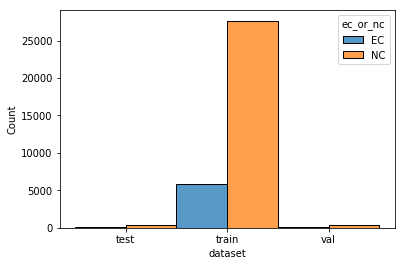

In [20]:
sns.histplot(data=whole_data, x="dataset", hue="ec_or_nc", multiple="dodge", shrink=1,fill=True)

## Sequence Lengths

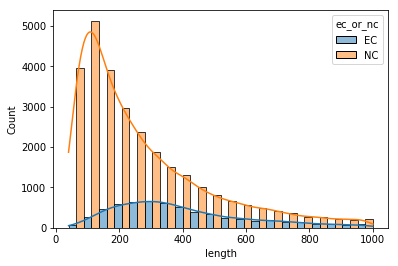

In [28]:
sns.histplot(data=whole_data, x="length", bins=20,hue="ec_or_nc",multiple="dodge", kde=True)

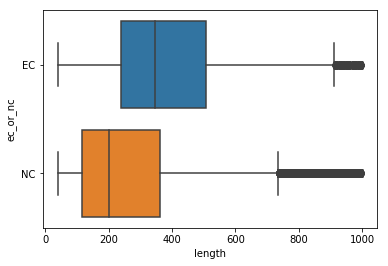

In [31]:
ax = sns.boxplot(x="length",y="ec_or_nc",data=whole_data)

# Multiclass

In [69]:
check_for=['1.','2.','3.','4.','5.','6.','7.']
whole_data['class'] = None
for check_string in check_for:
    whole_data.loc[whole_data['EC'].str.startswith(check_string, na=False),'class']=check_string

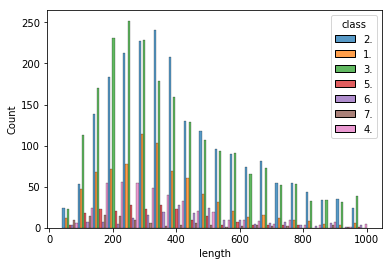

In [71]:
sns.histplot(data=whole_data, x="length", bins=20,hue="class",multiple="dodge") #sequence lengths

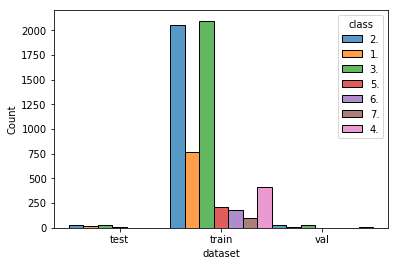

In [74]:
sns.histplot(data=whole_data, x="dataset",hue="class",multiple="dodge") #sequence lengths